Set configuration for this measurement

In [1]:
# config_path = r'power_dep_resonator.toml'
config_path = r'measurement_window_finding.toml'

import tomlkit

# Assuming 'config.toml' is your file
with open(config_path, 'r') as file:
    content = file.read()
    sweepLF_config = tomlkit.parse(content)



config parser

In [2]:


vna_address = sweepLF_config["hardware"]["address"]
vna_model = sweepLF_config["hardware"]["model"]
vna_port = sweepLF_config["hardware"]["port"]

measurements = sweepLF_config["measurement"]
attenuation = sweepLF_config["hardware"]["attenuation"]



Load packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


Connect with VNA

In [4]:

from driver import get_VNA

vna = get_VNA(vna_address,vna_model)

vna.check_error()




Connected to: Rohde-Schwarz ZNB20-4Port (serial:1334333064101393, firmware:3.32) in 3.09s
Connected to: {'vendor': 'Rohde-Schwarz', 'model': 'ZNB20-4Port', 'serial': '1334333064101393', 'firmware': '3.32'}


Measurement

In [5]:
from scipy.signal import find_peaks, peak_widths

def measure_and_find_peak(port, start, stop, points, power, IF_bandwidth):
    # Perform a frequency sweep
    freq_array, s_params = vna.lin_freq_sweep(start, stop, points, port, power, IF_bandwidth)
    
    # Extract magnitude from S-parameters
    magnitude = 20 * np.log10(np.abs(s_params))
    
    # Find peaks in the magnitude response
    peaks, _ = find_peaks(-magnitude)  

    if len(peaks) > 0:
        peak_index = peaks[np.argmin(magnitude[peaks])]
        peak_frequency = freq_array[peak_index]

        # Find the full width at half maximum (FWHM) of the peak
        results_half = peak_widths(-magnitude, [peak_index], rel_height=0.5)
        fwhm = results_half[0][0] * (freq_array[1] - freq_array[0])

        # Determine new start and stop frequencies based on the peak and FWHM
        new_start = peak_frequency - 15 * fwhm
        new_stop = peak_frequency + 15 * fwhm

        return new_start, new_stop
    else:
        raise ValueError("未找到向下的峰")

resonatorfre = []

for m_task in measurements:
    print(m_task)
    deltafre = m_task['frequency']['deltafre']
    resonator_fre = m_task["frequency"]["resonator_fre"]
    sweep_point = m_task["frequency"]["points"]
    vna_power = m_task["power"]
    IF_bandwidth = m_task["IF_bandwidth"]

# for freq in input_frequencies:
    start_freq = resonator_fre - deltafre
    stop_freq = resonator_fre + deltafre
    
    try:
        # Perform the initial measurement and find the peak
        new_start, new_stop = measure_and_find_peak(vna_port, start_freq, stop_freq, sweep_point, vna_power, IF_bandwidth)
        
        # Adjust the frequency range and measure again
        new_start, new_stop = measure_and_find_peak(vna_port, new_start, new_stop, sweep_point, vna_power, IF_bandwidth)
        
        resonatorfre.append([new_start, new_stop])
    except ValueError as e:
        print(f"在頻率 {resonator_fre} 附近未找到向下的峰：{e}")

    # print(f"輸入頻率 {resonator_fre[m_task]} 的新頻率範圍：{new_start} - {new_stop}")
    print(f'{resonator_fre} \n start = {new_start} \n stop = {new_stop}')



{'IF_bandwidth': 1000, 'power': -20, 'frequency': {'deltafre': 10000000.0, 'resonator_fre': 4761200000.0, 'points': 501}}
4761200000.0 
 start = 4761019595.103903 
 stop = 4761376427.752098


plot

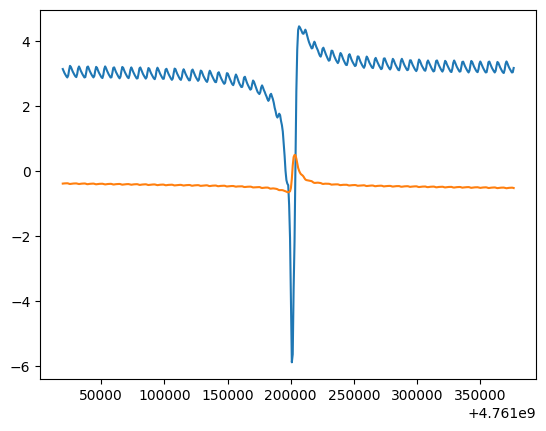

0 
 start = 4761019595.103903 
 stop = 4761376427.752098


In [6]:
for i, (new_start, new_stop) in enumerate(resonatorfre):

    freq_array, s_params = vna.lin_freq_sweep(new_start, new_stop, 501, vna_port, vna_power, 1000)
    plt.plot(freq_array, 20*np.log10(np.abs(s_params)))
    plt.plot(freq_array, np.angle(s_params))
    plt.show()
    print(f'{i} \n start = {new_start} \n stop = {new_stop}')